In [3]:
import pandas as pd
import sqlite3
import json
import altair as alt
alt.renderers.enable("svg")

RendererRegistry.enable('svg')

## Paths to database and lookup table

In [4]:
lookup_table = pd.read_csv('../data/processed/category_codes_q4_final.csv')

In [1]:
#folder for charts
chart_path = ""
#folder for output files
output_files_path = ""

In [5]:
db = sqlite3.connect('../data/processed/2024-q4_data.db')
cursor = db.cursor()

## Helper functions

In [6]:
def sql_execute(query):
    cursor.execute(query)
    return cursor.fetchall()

In [7]:
def decode_category(code, lookup_table):
    """given a category code, return the category name, based on a lookup table"""
    if code is not None and code != "None":
        if isinstance(code, str) and code.startswith("["):
            code = json.loads(code)
            result = [lookup_table[lookup_table['code'] == c].iloc[0]['category'] for c in code]
        else:
            result = lookup_table[lookup_table['code'] == code].iloc[0]['category']
        if isinstance(code, list) and len(code) == 1:
            return str(code[0])
        else:
            return str(result)
    else:
        return None

In [8]:
def decode_df(df, lookup_table, numeric_cols=[]):
    """given a dataframe and a lookup table, decode the category codes in the dataframe"""
    for col in df.columns:
        if col not in numeric_cols:
            df[col] = df[col].apply(lambda x: decode_category(float(x), lookup_table) if pd.notna(x) else x)
    return df

In [9]:
def generate_freq_query(column):
    """generates an sql query that counts the frequency of values in a given column"""
    return f'SELECT {column}, COUNT(*) as frequency FROM categorized_data GROUP BY {column}'

In [10]:
def generate_bar_chart(df, x, y, title):
    chart = alt.Chart(df).mark_bar().encode(
        x=x,
        y=y
    ).properties(
        title =title
    )
    return chart

# Statements of reasons per platform

In [11]:
all_decisions = pd.DataFrame(sql_execute(generate_freq_query("platform_name")),
                                      columns=['platform', 'decisions']
                                      ).sort_values(by='decisions', ascending=False)

In [12]:
all_decisions = decode_df(all_decisions, lookup_table, numeric_cols=["decisions"])

col:  platform


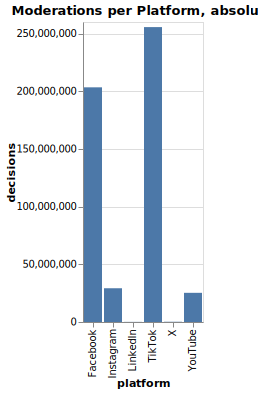

In [15]:
generate_bar_chart(all_decisions, 'platform', 'decisions', 'Moderations per Platform, absolute')

# Detection and decision types per platform
(human vs automated)

**Detections:**

In [16]:
detection_query = '''SELECT 
                        platform_name,
                        automated_detection,
                        COUNT(*) AS count
                    FROM 
                        categorized_data
                    GROUP BY 
                        platform_name,
                        automated_detection'''

In [17]:
detection_types = pd.DataFrame(sql_execute(detection_query),
                                        columns=['platform', 'automated_detection', 'count']
                                        )
detection_types = decode_df(detection_types, lookup_table, numeric_cols=["count"])

col:  platform
col:  automated_detection


In [18]:
detection_types["total_count_pP"] = detection_types.groupby('platform')['count'].transform('sum')
detection_types["share_pP"] = detection_types["count"] / detection_types["total_count_pP"] *100
detection_types["total_count"] = detection_types["count"].sum()
detection_types["share"] = detection_types["count"] / detection_types["total_count"] *100

In [19]:
automated_vs_human = detection_types.groupby('automated_detection').agg({'count': 'sum'})
automated_vs_human["share"] = automated_vs_human["count"] / automated_vs_human["count"].sum() * 100

In [84]:
detection_types.to_csv(output_files_path, index=False)

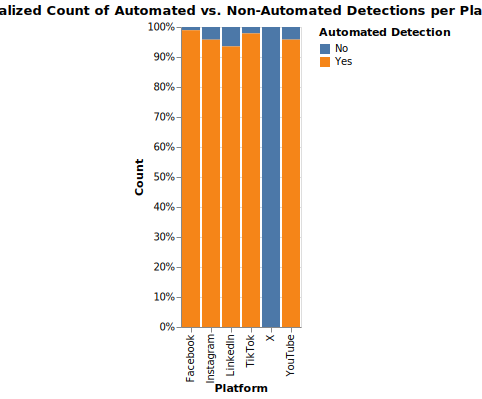

In [20]:
detection_types
chart = alt.Chart(detection_types).mark_bar().encode(
    x=alt.X('platform', title='Platform'),
    y=alt.Y('count', title='Count', stack='normalize'),
    color=alt.Color('automated_detection', title='Automated Detection')
).properties(
    title="Normalized Count of Automated vs. Non-Automated Detections per Platform"
)
chart.show()
chart.save(chart_path+'/automated_detection_per_platform.svg')

**Decisions:**

In [21]:
decision_query = '''SELECT 
                        platform_name,
                        automated_decision,
                        COUNT(*) AS count
                    FROM 
                        categorized_data
                    GROUP BY 
                        platform_name,
                        automated_decision'''

In [22]:
decision_types = pd.DataFrame(sql_execute(decision_query),
                                        columns=['platform', 'automated_decision', 'count']
                                        )
decision_types = decode_df(decision_types, lookup_table, numeric_cols=["count"])

col:  platform
col:  automated_decision


In [23]:
decision_types["total_count_pP"] = decision_types.groupby('platform')['count'].transform('sum')
decision_types["share_pP"] = decision_types["count"] / decision_types["total_count_pP"] *100
decision_types["total_count"] = decision_types["count"].sum()
decision_types["share"] = decision_types["count"] / decision_types["total_count"] *100

In [24]:
#rename category
decision_types["automated_decision"] = decision_types["automated_decision"].apply(
    lambda x: "Autom." if x == "AUTOMATED_DECISION_FULLY" else "teilautom." if x == "AUTOMATED_DECISION_PARTIALLY" else "Human"
)

In [25]:
decision_types.to_csv(output_files_path+'/decision_types.csv', index=False)

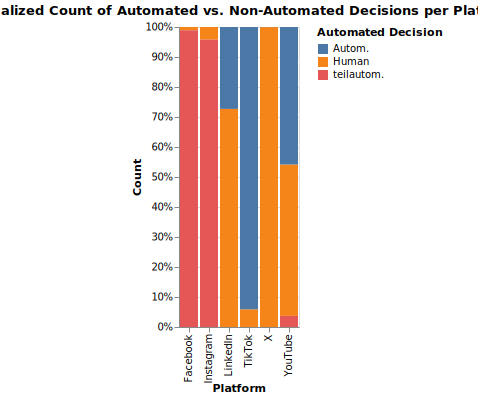

In [26]:
chart = alt.Chart(decision_types).mark_bar().encode(
    x=alt.X('platform', title='Platform'),
    y=alt.Y('count', title='Count', stack='normalize'),
    color=alt.Color('automated_decision', title='Automated Decision')
).properties(
    title="Normalized Count of Automated vs. Non-Automated Decisions per Platform"
)
chart.show()
chart.save(chart_path+'/automated_decision_per_platform.svg')

Decision per Detection

In [27]:
decision_detection_query = '''SELECT 
                        platform_name,
                        automated_detection,
                        automated_decision,
                        COUNT(*) AS count
                    FROM 
                        categorized_data
                    GROUP BY 
                        platform_name,
                        automated_detection,
                        automated_decision'''

In [28]:
decision_detection = pd.DataFrame(sql_execute(decision_detection_query),
                                        columns=['platform', 'automated_detection', 'automated_decision', 'count']
                                        )
decision_detection = decode_df(decision_detection, lookup_table, numeric_cols=["count"])

col:  platform
col:  automated_detection
col:  automated_decision


Share of automated vs human detection and decision:

In [29]:
decision_detection_distribution = decision_detection.groupby(["automated_detection", "automated_decision"]).agg({'count': 'sum'})
decision_detection_distribution["share"] = decision_detection_distribution["count"] / decision_detection_distribution["count"].sum() * 100

In [30]:
decision_detection_distribution = decision_detection_distribution.reset_index()
decision_detection_distribution["automated_decision"] = decision_detection_distribution["automated_decision"].apply(
    lambda x: "Autom." if x == "AUTOMATED_DECISION_FULLY" else "teilautom." if x == "AUTOMATED_DECISION_PARTIALLY" else "Human"
)

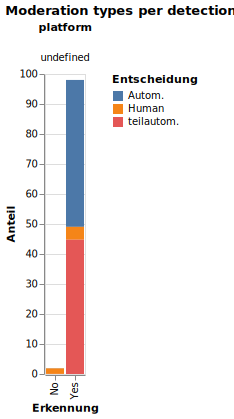

In [31]:
chart = alt.Chart(decision_detection_distribution).mark_bar().encode(
    x=alt.X('automated_detection', title='Erkennung'),
    y=alt.Y('share', title='Anteil'),
    color=alt.Color('automated_decision', title='Entscheidung')
).facet(
    column='platform'
).properties(
    title="Moderation types per detection type"
)
chart.show()

# Sources per platform

In [32]:
source_type_query = '''SELECT platform_name, source_type, COUNT() as count
                        FROM categorized_data
                        GROUP BY platform_name, source_type'''

In [33]:
source_type = pd.DataFrame(sql_execute(source_type_query),
                                        columns=['platform', 'source_type', 'count']
                                        )
source_type = decode_df(source_type, lookup_table, numeric_cols=["count"])

col:  platform
col:  source_type


In [34]:
source_type["total_count"] = source_type.groupby('platform')['count'].transform('sum')
source_type["share"] = source_type["count"] / source_type["total_count"] *100

In [35]:
trusted_flagger = source_type[source_type["source_type"] == "SOURCE_TRUSTED_FLAGGER"]

In [36]:
#rename categories
source_type["source_type"] = source_type["source_type"].apply(lambda x: "Art16" if x == "SOURCE_ARTICLE_16" else "trusted flagger" if x == "SOURCE_TRUSTED_FLAGGER" else "voluntary" if x == "SOURCE_VOLUNTARY" else "andere")

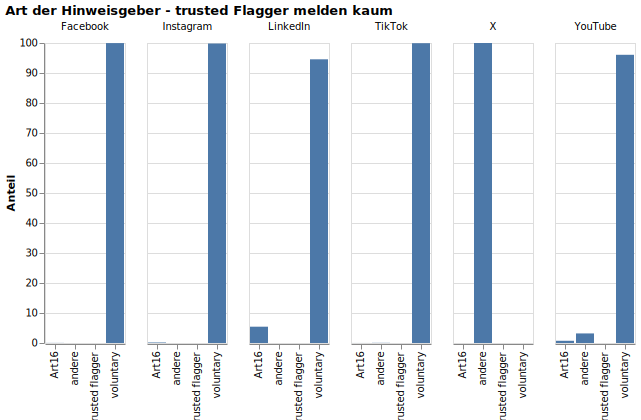

In [37]:
chart = alt.Chart(source_type).mark_bar().encode(
    x=alt.X('source_type', title=''),
    y=alt.Y('share', title='Anteil'),
    column=alt.Column('platform', title='')
).properties(
    title="Art der Hinweisgeber - trusted Flagger melden kaum"
)
chart.show()
chart.save(chart_path+'/source_type.svg')

# reasons for moderation per platform

In [38]:
category_query = '''SELECT 
                        platform_name,
                        category,
                        automated_detection,
                        automated_decision,
                        COUNT(*) AS count
                    FROM 
                        categorized_data
                    GROUP BY 
                        platform_name,
                        category'''

In [39]:
categories = pd.DataFrame(sql_execute(category_query),
                                        columns=['platform', 'category', 'automated_detection', 'automated_decision', 'count']
                                        )
categories = decode_df(categories, lookup_table, numeric_cols=["count"])

col:  platform
col:  category
col:  automated_detection
col:  automated_decision


In [40]:
categories["total_count"] = categories.groupby('platform')['count'].transform('sum')
categories["share"] = categories["count"] / categories["total_count"] *100

In [43]:
#rename categories
categories["category"] = categories["category"].apply(lambda x: " ".join(x.replace("STATEMENT_CATEGORY_", "").split("_")).title())

In [44]:
category_grouping = {"Gewalt und Gefahr": ["Animal Welfare", "Risk For Public Security", "Violence", "Self Harm", "Protection Of Minors", "Unsafe And Illegal Products"],
                     "Hass und Hetze": ["Illegal Or Harmful Speech"],
                     "Betrug und Manipulation": ["Negative Effects On Civic Discourse Or Elections", "Scams And Fraud"],
                     "Geistiges Eigentum und Datenschutz": ["Data Protection And Privacy Violations", "Intellectual Property Infringements", "Non Consensual Behaviour"],
                     "Pornografie und Sexuelles": ["Pornography Or Sexualized Content"],
                     "Bestimmungen der Plattform": ["Scope Of Platform Service"]}

In [45]:
categories["category"] = categories["category"].apply(
    lambda x: next((key for key, values in category_grouping.items() if x in values), x)
)

In [51]:
categories_count = categories.groupby(['category', 'automated_detection', 'automated_decision'])['count'].sum().reset_index(name='count')

,category,automated_detection,automated_decision,count
0,Bestimmungen der Plattform,No,AUTOMATED_DECISION_NOT_AUTOMATED,11117016
1,Bestimmungen der Plattform,Yes,AUTOMATED_DECISION_FULLY,113323973
2,Bestimmungen der Plattform,Yes,AUTOMATED_DECISION_PARTIALLY,211313535
3,Betrug und Manipulation,No,AUTOMATED_DECISION_NOT_AUTOMATED,13259
4,Betrug und Manipulation,Yes,AUTOMATED_DECISION_FULLY,12734160
5,Betrug und Manipulation,Yes,AUTOMATED_DECISION_NOT_AUTOMATED,1730
6,Betrug und Manipulation,Yes,AUTOMATED_DECISION_PARTIALLY,13798387
7,Geistiges Eigentum und Datenschutz,No,AUTOMATED_DECISION_NOT_AUTOMATED,87356
8,Geistiges Eigentum und Datenschutz,No,AUTOMATED_DECISION_PARTIALLY,959387
9,Geistiges Eigentum und Datenschutz,Yes,AUTOMATED_DECISION_FULLY,1869383


In [52]:
categories_count["share"] = categories_count["count"] / categories_count["count"].sum() *100

In [58]:
categories_all_platforms = categories_count.groupby(["automated_detection", "automated_decision"])["count"].sum().reset_index(name="total_count")
categories_all_platforms["share"] = categories_all_platforms["total_count"] / sum(categories_all_platforms["total_count"]) *100

# Moderation speed per platform

In [60]:
speed_query = '''SELECT 
                    platform_name, 
                    AVG(decision_speed_seconds) as avg_time_to_decision
                FROM 
                    categorized_data 
                GROUP BY 
                    platform_name
                '''
speed_avg = pd.DataFrame(sql_execute(speed_query), columns=['platform', 'avg_time_to_decision'])

In [61]:
speed_avg["days"] = speed_avg["avg_time_to_decision"] / 86400
speed_avg = decode_df(speed_avg, lookup_table, numeric_cols=["avg_time_to_decision", "days"])

col:  platform


In [281]:
speed_avg.to_csv(output_files_path+'/speed_avg.csv', index=False)

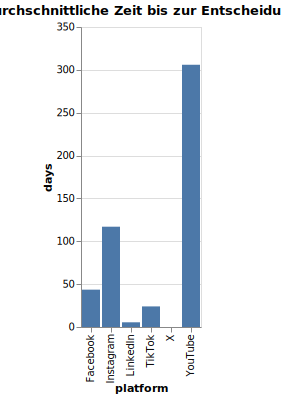

In [64]:
generate_bar_chart(speed_avg, 'platform', 'days', 'Durchschnittliche Zeit bis zur Entscheidung')

# Reaktionsgeschwindigkeit gesamt und pro Plattform je nach Detection, Decision, Source, und Kategorie

In [74]:
speed_histogram_query = '''SELECT 
                            decision_speed_seconds,
                            COUNT(decision_speed_seconds)
                          FROM 
                            categorized_data
                          GROUP BY 
                            decision_speed_seconds
                          ORDER BY 
                            decision_speed_seconds
                          '''

In [75]:
speed_histogram = pd.DataFrame(sql_execute(speed_histogram_query), columns=['speed_days', 'count'])

In [444]:
speed_per_detection_query = '''SELECT platform_name, automated_detection, AVG(decision_speed_seconds) as avg_speed
                                FROM categorized_data
                                GROUP BY platform_name, automated_detection'''

In [445]:
speed_per_detection = pd.DataFrame(sql_execute(speed_per_detection_query),
                                        columns=['platform', 'automated_detection', 'speed_seconds'])

In [446]:
speed_per_detection["platform"] = speed_per_detection["platform"].apply(lambda x: decode_category(x, lookup_table))
speed_per_detection["automated_detection"] = speed_per_detection["automated_detection"].apply(lambda x: decode_category(x, lookup_table))
speed_per_detection["automated_detection"] = speed_per_detection["automated_detection"].apply(lambda x: "automated" if x == "Yes" else "human")

In [447]:
speed_per_detection["speed_days"] = speed_per_detection["speed_seconds"].apply(lambda x: x/86400)

In [ ]:
chart = alt.Chart(speed_per_detection).mark_bar().encode(
    x=alt.X('automated_detection', title=''),
    y=alt.Y('speed_days', title='Tage'),
    column="platform"
).properties(
    title="Dauer bis zur Moderation je nach Art der Erkennung"
)
chart.show()

Decision:

In [455]:
speed_per_decision_query = '''SELECT platform_name, automated_decision, AVG(decision_speed_seconds) as avg_speed
                                FROM categorized_data
                                GROUP BY platform_name, automated_decision'''

In [456]:
speed_per_decision = pd.DataFrame(sql_execute(speed_per_decision_query),
                                        columns=['platform', 'automated_decision', 'speed_seconds'])

In [457]:
speed_per_decision["platform"] = speed_per_decision["platform"].apply(lambda x: decode_category(x, lookup_table))
speed_per_decision["automated_decision"] = speed_per_decision["automated_decision"].apply(lambda x: decode_category(x, lookup_table))
speed_per_decision["speed_days"] = speed_per_decision["speed_seconds"].apply(lambda x: x/86400)

In [459]:
speed_per_decision["automated_decision"] = speed_per_decision["automated_decision"].apply(lambda x: "automated" if x == "AUTOMATED_DECISION_FULLY" else "teilautom." if x == "AUTOMATED_DECISION_PARTIALLY" else "human")

In [ ]:
chart = alt.Chart(speed_per_decision).mark_bar().encode(
    x=alt.X('automated_decision', title=''),
    y=alt.Y('speed_days', title='Tage'),
    column="platform"
).properties(
    title="Dauer bis zur Moderation je nach Art der Entscheidung"
)
chart.show()

Kategorie:

In [465]:
speed_per_category_query = '''SELECT platform_name, category, AVG(decision_speed_seconds) as avg_speed
                                FROM categorized_data
                                GROUP BY platform_name, category'''

In [463]:
speed_per_category = pd.DataFrame(sql_execute(speed_per_category_query),
                                        columns=['platform', 'category', 'speed_seconds'])

In [466]:
speed_per_category["platform"] = speed_per_category["platform"].apply(lambda x: decode_category(x, lookup_table))
speed_per_category["category"] = speed_per_category["category"].apply(lambda x: decode_category(x, lookup_table))
speed_per_category["speed_days"] = speed_per_category["speed_seconds"].apply(lambda x: x/86400)

In [469]:
speed_per_category["category"] = speed_per_category["category"].apply(lambda x: " ".join(x.replace("STATEMENT_CATEGORY", "").split("_")).title())

In [ ]:
chart = alt.Chart(speed_per_category).mark_bar().encode(
    x=alt.X('category', title=''),
    y=alt.Y('speed_days', title='Tage')
).facet( 
    column="platform"
).properties(
    title="Tage zwischen Content-VÖ und Moderationsentscheidung je nach Plattform und Kategorie",
)
chart.show()

Hinweisgeber:

In [477]:
speed_per_sourcetype_query = '''SELECT platform_name, source_type, AVG(decision_speed_seconds) as avg_speed
                                FROM categorized_data
                                GROUP BY platform_name, source_type'''

In [478]:
speed_per_source = pd.DataFrame(sql_execute(speed_per_sourcetype_query),
                                        columns=['platform', 'source_type', 'speed_seconds'])

In [479]:
speed_per_source["platform"] = speed_per_source["platform"].apply(lambda x: decode_category(x, lookup_table))
speed_per_source["source_type"] = speed_per_source["source_type"].apply(lambda x: decode_category(x, lookup_table))
speed_per_source["speed_days"] = speed_per_source["speed_seconds"].apply(lambda x: x/86400)

In [480]:
speed_per_source["source_type"] = speed_per_source["source_type"].apply(lambda x: "Art16" if x == "SOURCE_ARTICLE_16" else "trusted flagger" if x == "SOURCE_TRUSTED_FLAGGER" else "voluntary" if x == "SOURCE_VOLUNTARY" else "andere")

In [ ]:
chart = alt.Chart(speed_per_source).mark_bar().encode(
    x=alt.X('source_type', title=''),
    y=alt.Y('speed_days', title='Tage')
).facet( 
    column="platform"
).properties(
    title="Tage zwischen Content-VÖ und Moderationsentscheidung je nach Hinweisgeber",
)
chart.show()

# 

# Strafen

In [76]:
vis_decisions_query = '''SELECT platform_name, decision_visibility, COUNT() as count
                                FROM categorized_data
                                GROUP BY platform_name, decision_visibility'''
account_decision_query = '''SELECT platform_name, decision_account, COUNT() as count
                                FROM categorized_data
                                GROUP BY platform_name, decision_account'''
monetary_decision_query = '''SELECT platform_name, decision_monetary, COUNT() as count
                                FROM categorized_data
                                GROUP BY platform_name, decision_monetary'''
provision_decision_query = '''SELECT platform_name, decision_provision, COUNT() as count
                                FROM categorized_data
                                GROUP BY platform_name, decision_provision'''

In [77]:
vis_decisions = pd.DataFrame(sql_execute(vis_decisions_query),
                                        columns=['platform', 'visibility_moderation', 'count'])

In [ ]:
vis_decisions = decode_df(vis_decisions, lookup_table, numeric_cols=["count", "platform"])
vis_decisions["total_count"] = vis_decisions.groupby('platform')['count'].transform('sum')
vis_decisions["share"] = vis_decisions["count"] / vis_decisions["total_count"] *100
vis_decisions["visibility_moderation"] = vis_decisions["visibility_moderation"].fillna("").apply(lambda x: x.replace("DECISION_VISIBILITY_", "").title())

In [277]:
vis_decisions.to_csv(output_files_path+'/visibility_decisions.csv', index=False)

In [278]:
monetary_decisions = pd.DataFrame(sql_execute(monetary_decision_query),
                                        columns=['platform', 'monetary_moderation', 'count'])

In [284]:
monetary_decisions = decode_df(monetary_decisions, lookup_table, numeric_cols=["count"]).fillna("")
monetary_decisions["total_count"] = monetary_decisions.groupby('platform')['count'].transform('sum')
monetary_decisions["share"] = monetary_decisions["count"] / monetary_decisions["total_count"] *100
monetary_decisions["monetary_moderation"] = monetary_decisions["monetary_moderation"].apply(lambda x: x.replace("DECISION_MONETARY_", "").title())

In [285]:
monetary_decisions.to_csv(output_files_path+'/monetary_decisions.csv', index=False)

In [286]:
provision_decisions = pd.DataFrame(sql_execute(provision_decision_query),  columns=['platform', 'provision_moderation', 'count'])

In [362]:
provision_decisions['provision_moderation'] = provision_decisions['provision_moderation'].replace('', None)

In [403]:
provision_decisions = decode_df(provision_decisions, lookup_table, numeric_cols=["count", "platform"])
provision_decisions["total_count"] = provision_decisions.groupby('platform')['count'].transform('sum')
provision_decisions["share"] = provision_decisions["count"] / provision_decisions["total_count"] *100
provision_decisions["provision_moderation"] = provision_decisions["provision_moderation"].fillna("").apply(lambda x: x.replace("DECISION_PROVISION_", "").title())
provision_decisions.to_csv(output_files_path+'/provision_decisions.csv', index=False)

In [298]:
account_decisions = pd.DataFrame(sql_execute(account_decision_query),
                                        columns=['platform', 'account_moderation', 'count'])

In [ ]:
account_decisions = decode_df(account_decisions, lookup_table, numeric_cols=["platform", "count"]).fillna("")

In [359]:
account_decisions["total_count"] = account_decisions.groupby('platform')['count'].transform('sum')
account_decisions["share"] = account_decisions["count"] / account_decisions["total_count"] *100
account_decisions["account_moderation"] = account_decisions["account_moderation"].fillna("").apply(lambda x: x.replace("DECISION_ACCOUNT_", "").title())
account_decisions.to_csv('../data/processed/account_decisions.csv', index=False)

In [455]:
# Concatenate the dataframes
all_decisions = pd.concat([vis_decisions, account_decisions, monetary_decisions, provision_decisions])

# Melt the dataframe to combine moderation columns into one
all_decisions = all_decisions.melt(
    id_vars=['platform', 'count', 'total_count', 'share'],
    value_vars=['visibility_moderation', 'account_moderation', 'monetary_moderation', 'provision_moderation'],
    var_name='moderation_type',
    value_name='moderation'
).drop(columns=["share", "total_count"])

# Drop rows with NaN values in the 'moderation' column
all_decisions = all_decisions.dropna(subset=['moderation'])
all_decisions = all_decisions[all_decisions['moderation'] != "Nan"]
all_decisions = all_decisions[all_decisions['moderation'] != ""]
# Calculate the total number of decisions for each platform
all_decisions["platform_total_count"] = all_decisions.groupby('platform')['count'].transform('sum')

# Calculate overall share
all_decisions["share"] = all_decisions["count"] / all_decisions["platform_total_count"] * 100

# Calculate the share of each type of moderation among all
moderation_share = all_decisions.groupby(['platform', 'moderation_type'])['count'].sum() / all_decisions.groupby('platform')['count'].sum() * 100
moderation_share = moderation_share.reset_index().rename(columns={'count': 'Anteil Moderationstyp pP'})

# Calculate the share of Content_Removed for each platform
visibility_moderations = all_decisions[all_decisions['moderation_type'] == 'visibility_moderation'].copy()
visibility_moderations["total_visibility_moderations"] = visibility_moderations.groupby('platform')['count'].transform('sum')
visibility_moderations["share_content_removed"] = visibility_moderations["count"] / visibility_moderations["total_visibility_moderations"] * 100

# Select relevant columns
content_removed = visibility_moderations[visibility_moderations['moderation'] == 'Content_Removed'][['platform', 'share_content_removed']]
content_removed.to_csv(output_files_path+'/Anteil_gelöscht_visibility_moderations.csv', index=False, sep=";")

In [456]:
moderation_type_dict = {
    "account_moderation": "Account gesperrt/gelöscht",
    "visibility_moderation": "Sichtbarkeit des Beitrags eingeschränkt/gelöscht",
    "provision_moderation": "Account eingeschränkt",
    "monetary_moderation": "Monetarisierung ausgesetzt/beendet"
}
#source: https://transparency.dsa.ec.europa.eu/page/api-documentation#statement-attributes

In [457]:
moderation_share["moderation_type"] = moderation_share['moderation_type'].apply(lambda x: moderation_type_dict[x])

In [458]:
moderation_share.to_csv(output_files_path+'/moderation_share.csv', index=False, sep=";")